## Введением

__Генетические алгоритмы__ очень похожи на процесс естественного отбора, который был Чарльзом Дарвином. В общем смысле, мы можем понять как работает естественный процесс и как он связан с генетическим алгоритмом, используя следующее описание:

* стартуем с начальной популяции, которая будет иметь определенный вид, например такой, как на рисунке

<img src="https://miro.medium.com/max/1400/1*uqQLuhCeqbfyOyHtPt3Ixg.png" width="400" height="100">

* начальная популяция будет протестирована для понимания того, насколько хороших результатов можно добиться с такой популяцией, оценивать качество работы мы можем с помощью любой классической метрики машинного обучения - accuracy, precision, recall, F1-score, ROC-AUC

* основываясь на значениях метрики, мы выберем наиболее успешных родителей (этап "выживания наиболее приспособленных")

<img src="https://miro.medium.com/max/1400/1*9mrDW_6WWBuggN6pGLinwg.png" width="400" height="100">

* проведем спаривание родителей из выжевшей популяции, для производства потомства. Спаривание проводим с помощью двух шагов: кроссовер / рекомбинация и мутация. В случае кроссовера, гены (параметры) от родителей спаривания будут рекомбинированы, чтобы произвести потомство, с каждым ребенком, который наследует некоторые гены (параметры) от каждого родителя.

<img src="https://miro.medium.com/max/1400/1*h-rR-u4oyCZy39m4v-Pvhg.png" width="400" height="100">

* в случае, мутации, некоторые значения генов (параметров) будут изменены, чтобы сохранить генетическое разнообразие. Это позволяет генетическому алгоритму, обычно, находить наилучшее решение.

<img src="https://miro.medium.com/max/1400/1*Zlcm1KQCD3Enzx5F1WhufQ.png" width="400" height="100">

* в конечном счете, мы получим такие значения, которые будут содержать часть от выживших родителей (хороший ген), так и детей (новый ген). Мы сохраняем выживших родителей, чтобы сохранить наилучшие параметры физической формы на случай, если ценность физической подготовки потомства окажется хуже, чем у родителей.

## Genetic Algorithm for hyperparams optimization

Будем использовать генетический алгоритм для оптимизации гиперпараметров модели XGBoost. XGBoost - одна из наиболее популярных реализацией алгоритма градиентного бустинга, хорошо оптимизированная библиотека, которая обеспечивает высокую эффективность, гибкость и высокую переносимость. 

## Инициализация

Первый шаг генетического алгоритма - инициализация. Шаг, на котором происходит инициализация параметров случайным образом для создания популяции. В результате, мы получим первое поколение популяции, которое изображено на рисунке 1. Будем настраивать следующие параметры XGBoost:
* max_depth - максимальная глубина отдельного дерева;
* min_child_weight - минимальная сумма весов объектов, необходимая для разбиения дерева;
* subsample - доля объектов, которая будет использована для обучения отдельного дерева;
* colsample_bytree - доля признаков, которая используется для построения каждого отдельного дерева;
* gamma - минимальное значение функции потерь, при котором возможно разбиение в вершине дерева.

Подробное описание всех гиперпараметров алгоритма:
https://xgboost.readthedocs.io/en/latest/parameter.html

In [21]:
from typing import Dict
from copy import deepcopy
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
data = pd.read_csv("/content/gdrive/My Drive/train.csv")
data = data.sample(50000).reset_index(drop=True)

data.head(n=2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,274498,0,Revolving loans,F,N,Y,0,135000.0,270000.0,13500.0,270000.0,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.019101,-21457,365243,-280.0,-874,NaN,1,0,0,1,0,0,NaN,1.0,2,2,TUESDAY,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-733.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0,PUSH
1,332772,1,Cash loans,F,N,Y,0,162000.0,1546020.0,45202.5,1350000.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.019101,-17954,-2651,-7722.0,-1483,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2403.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0,PUSH


In [24]:
x_train, x_valid = train_test_split(
    data, train_size=15000, random_state=1
)
x_train = x_train.reset_index(drop=True)
x_valud = x_valid.reset_index(drop=True)

y_train, y_valid = x_train["TARGET"], x_valid["TARGET"]

In [25]:
def init_population(number_of_parents: int) -> Dict[str, np.array]:
    """
    Инициализация начальной популяции генетического алгоритма.

    Parameters
    ----------
    number_of_parents: int
        Количество родителей в популяции.

    Returns
    -------
    population: dict, Dict[str, np.array]
        Словарь с начальной популяцией.

    """
    population = {
        "max_depth": np.empty([number_of_parents, 1], dtype=np.uint8),
        "min_child_weight": np.empty([number_of_parents, 1], dtype=np.uint8),
        "subsample": np.empty([number_of_parents, 1]),
        "colsample_bytree": np.empty([number_of_parents, 1]),
        "gamma": np.empty([number_of_parents, 1])
    }

    for i in range(number_of_parents):
        population["max_depth"][i] = round(
            random.randrange(1, 10, step=1)
        )
        population["min_child_weight"][i] = round(
            random.uniform(0.01, 10), 2
        )
        population["subsample"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["colsample_bytree"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["gamma"][i] = round(
            random.uniform(0.01, 10), 2
        )
    return population

Ограничения на значения параметры наложены из рекомендаций документации XGBoost, либо на основании разумных предположений о возможном значении параметров.

## Селеция или отбор родителей

Второй шаг, обучим модель с использованием начальной популяции и вычислим значением метрики качества, будем использовать метрику ROC-AUC.

In [26]:
def train_population(population,
                     xgb_train: xgb.DMatrix,
                     xgb_valid: xgb.DMatrix,
                     y_valid: pd.Series
                     ):
    """
    Обучение модели на каждом значении population.
    После обучения модели, производится оценка качества
    модели с помощью метрики ROC-AUC на данных xgb_valid.

    Parameters
    ----------
    population: numpy.array
        Матрица с текущим значением популяции.

    xgb_train: xgb.DMatrix
        Выборка для обучения модели, в формате xgboost.DMatrix.

    xgb_valid: xgb.DMatrix
        Выборка для тестирования модели, в формате xgboost.DMatrix.

    y_valid: pd.Series
        Значение целевой переменной для тестирования модели.

    Returns
    -------
    scores: List[float]
        Список со значеним метрик качества.

    """
    scores = []
    for i in range(population.shape[0]):
        xgb_params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "learning_rate": 0.1,
            "max_depth": int(population[i][0]),
            "min_child_weight": population[i][1],
            "subsample": population[i][2],
            "colsample_bytree": population[i][3],
            "gamma": population[i][4],
            "eval_metric": "auc",
            "nthread": 6,
            "seed": 27
        }
        model = xgb.train(
            params=xgb_params,
            dtrain=xgb_train,
            evals=[(xgb_train, "train"), (xgb_valid, "valid")],
            early_stopping_rounds=50,
            num_boost_round=1000,
            verbose_eval=25,
        )
        y_pred = model.predict(xgb_valid)
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)
        print("="*84)

    return scores

In [27]:
num_features = x_train.select_dtypes(exclude=["object"]).columns
x_train, x_valid = x_train[num_features], x_valid[num_features]

to_drop = ["SK_ID_CURR", "TARGET"]
x_train = x_train.drop(to_drop, axis=1)
x_valid = x_valid.drop(to_drop, axis=1)

In [28]:
xgb_train = xgb.DMatrix(
    data=x_train, label=y_train
)
xgb_valid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

Определим, сколько родителей мы хотели бы выбрать, и создадим массив с выбранными родителями, основываясь на значениях метрики качества.

In [29]:
def select_new_parents(population: np.array, scores: list, num_parents: int):
    """
    Выбор оптимальный параметров популяции на основе
    значений метрики качества ROC-AUC.

    Parameters
    ----------
    population: np.array
        Матрица с текущим значением популяции.

    scores: List[float]
        Список со значениями метрики качества.

    num_parents: int
        Количество родителей, которые требуется отобрать.

    Returns
    -------
    selected_parents: np.array
        Значение популяции, отобранное на основе метрики качества.

    """
    scores = deepcopy(scores)
    selected_parents = np.empty((
        num_parents, population.shape[1]
    ))

    for parent_id in range(num_parents):
        best_result_id = np.where(scores == np.max(scores))
        best_result_id = best_result_id[0][0]

        selected_parents[parent_id, :] = population[best_result_id, :]
        scores[best_result_id] = -1

    return selected_parents

## Crossover

Существуют различные методы определения пересечения в случае генетических алгоритмов, такие как одноточечный, двухточечный и k-точечный кроссовер, равномерный кроссовер и кроссовер для упорядоченных списков. Мы будем использовать единый кроссовер, где каждый параметр для ребенка (нового объекта популяции) будет независимо выбираться из родителей на основе определенного распределения. В нашем случае, мы будем использовать дискретное равномерное распределение из numpy.random.

<div class="alert alert-block alert-success">
<p>Идея была в том, что отобрать двух "лучших" родителей. Далее лучшие родители между собой порождают двух потомков. <br>
После этого каждый из двух топовых родителей создает по одному потомку с половиной оставшихся особей. 
Каждый раз гены смешиваются пошагово случайно для каждого гена. <br>
Варианты алгоритмов с перестановкой генов не применимы для нашей задачи, поскольку каждый параметр модели приемлим только в определенном диапазоне<br>
Судя по метрикам, моя гипотеза провалилась, значительного улучшения качества модели нет, хотя в целом каждое следующее поколение имеет большую стабильность - нет явно провальных моделей после третьего поколения.
</p></div>

In [30]:
# def crossover_uniform(parents, children_size):
#     """
    
#     """
#     idx_1 = np.arange(
#         0, np.uint8(children_size[1]), 1, dtype=np.uint8
#     )
#     idx_2 = np.random.randint(
#         0, np.uint8(children_size[1]), np.uint(children_size[1]/2)
#     )
#     idx_3 = np.array(
#         list(set(idx_1) - set(idx_2))
#     )
#     children = np.empty(children_size)

#     for i in range(children_size[0]):
#         parent1_idx = i % parents.shape[0]
#         parent2_idx = (i+1) % parents.shape[0]

#         children[i, idx_2] = parents[parent1_idx, idx_2]
#         children[i, idx_3] = parents[parent2_idx, idx_3]

#     return children

def crossover_uniform(parents, children_size):
    num_top = 2
    children = parents.copy()
    
    # у двух лучший родителей появляется два потомка, обмениваясь случайными генами между собой
    children[0] = gens_swap(parents[0], parents[1], children_size[1])
    children[1] = gens_swap(parents[1], parents[0], children_size[1])
    
    # каждый из двух лучших родителей смешивает геном с половиной оставшихся особами порождая одного потомка
    for i in range(0, num_top):
        parterns_num = (children_size[0] - num_top) // num_top # кол-во смешений для лучшего родителя
        idx_shuffle = get_genes(children_size[1])
        for y in range(i*parterns_num+num_top, i*parterns_num + num_top + parterns_num):
            children[y] = gens_swap(parents[i], parents[y], children_size[1])

    return children


def get_genes(size): # выбор генов, которые будут смешиваться
    idx_shuffle = np.random.randint(0, 2, size)
    return idx_shuffle

def gens_swap(parent0, parent1, size): # замена генов при создание потомка
    child = [0]*size
    idx_swap = get_genes(size)
    for i in range(0, size):
        if idx_swap[i] == 1:
            child[i] = parent0[i]
        else:
            child[i] = parent1[i]
    return child

## Мутация

Последним шагом будет разнообразное построение потомков путем случайного выбора одного из параметров и изменения его на случайную величину. Мы также введем некоторые ограничения, чтобы ограничить измененные значения в определенном диапазоне. Пропуск этих ограничений может привести к возникновению ошибки.

In [31]:
def mutation(crossover, number_of_parameters):
    """
    Мутация объектов популяции, получение новых значений
    гиперпараметров для проверки гипотезы о повышении качества
    работы модели.

    Parameters
    ----------
    crossover: np.array
        Исходные объекты популяции.

    number_of_parameters: int
        Количество параметров.

    Returns
    -------
    crossover: np.array
        Мутированные объекты популяции.

    """
    min_max_values = np.zeros((number_of_parameters, 2))

    min_max_values[0, :] = [1, 15] # ограничение для max_depth
    min_max_values[1, :] = [0, 10] # ограничение для min_child_weight
    min_max_values[2, :] = [0.01, 1] # ограничение для subsample
    min_max_values[3, :] = [0.01, 1] # ограничение для colsample_bytree
    min_max_values[4, :] = [0.01, 10] # ограничение для gamma
    parameter_selected = np.random.randint(0, 5, 1)

    if parameter_selected == 0:
        mutation_value = np.random.randint(-5, 5, 1)
    elif parameter_selected == 1:
        mutation_value = round(np.random.uniform(5, 5), 2)
    elif parameter_selected == 2:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 3:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 4:
        mutation_value = round(np.random.uniform(-2, 2), 2)

    for idx in range(crossover.shape[0]):
        crossover[idx, parameter_selected] = crossover[idx, parameter_selected] + mutation_value
        if crossover[idx, parameter_selected] > min_max_values[parameter_selected, 1]:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 1]
        else:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 0]

    return crossover

## Вычислительный эксперимент

In [35]:
number_of_parents = 8
number_of_parents_mating = 4
number_of_parameters = 5
number_of_generation = 6

population_size = (number_of_parents, number_of_parameters)
scores_history = np.empty([number_of_generation+1, number_of_parents])

params_history = np.empty([(number_of_generation+1) * number_of_parents, number_of_parameters])

In [36]:
population = init_population(number_of_parents)

population = np.concatenate((
    population["max_depth"],
    population["min_child_weight"],
    population["subsample"],
    population["colsample_bytree"],
    population["gamma"]), axis=1)

params_history[0:number_of_parents, :] = population

In [37]:
for generation in tqdm(range(number_of_generation)):
    best_score, mean_score = np.max(scores_history), np.mean(scores_history)
    print(f"All-history: Best ROC-AUC = {round(best_score, 4)}, Mean ROC-AUC = {round(mean_score, 4)}")

    scores = train_population(
        population=population,
        xgb_train=xgb_train,
        xgb_valid=xgb_valid,
       y_valid=y_valid)

    scores_history[generation, :] = scores

    parents = select_new_parents(
        population=population,
        scores=scores,
        num_parents=4)

    children = crossover_uniform(
        parents=parents,
        children_size=(population_size[0] - parents.shape[0], 5)
    )
    children_mutated = mutation(children, number_of_parameters=5)
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = children_mutated

    params_history[(generation+1)*8 : (generation+1)*8+8 , :] = population
    clear_output()

scores_history = pd.DataFrame(scores_history)
scores_history = scores_history.loc[:5]





100%|██████████| 6/6 [06:49<00:00, 68.23s/it]


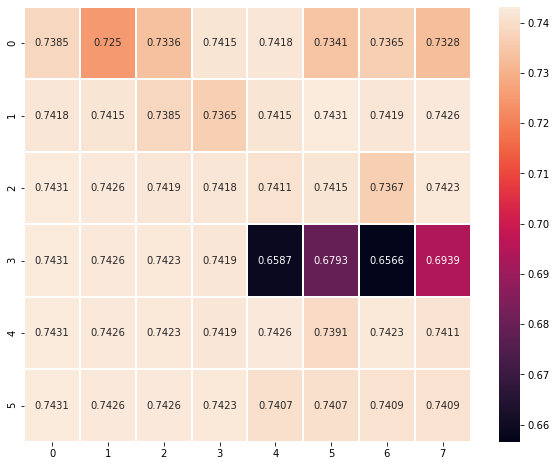

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(scores_history, annot=True, fmt='.4g', linewidths=1, ax=axes)